# IMPORT

In [ ]:
!pip install category_encoders

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    tf.random.set_seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

# LOAD DATASET

In [ ]:
light_df = pd.read_csv('경로/open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

In [ ]:
child_area_df = pd.read_csv('경로/open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [ ]:
child_area_df

,도시,구,동,cnt
0,대구광역시,남구,대명동,26
1,대구광역시,남구,봉덕동,8
2,대구광역시,남구,이천동,6
3,대구광역시,달성군,가창면,4
4,대구광역시,달성군,구지면,3
...,...,...,...,...
66,대구광역시,중구,봉산동,2
67,대구광역시,중구,삼덕동2가,1
68,대구광역시,중구,삼덕동3가,1
69,대구광역시,중구,서문로1가,1


In [ ]:
parking_df = pd.read_csv('경로/open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [ ]:
train_org = pd.read_csv('경로/open/train.csv')
test_org = pd.read_csv('경로/open/test.csv')

display(train_org.head())
display(test_org.head())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [ ]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [ ]:
test_df = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_df.columns].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_df

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,391.0,2.0,11.0,0.0,0.0
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,932.0,NaN,0.0,1.0,3.0
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,473.0,5.0,NaN,NaN,NaN
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,534.0,11.0,0.0,9.0,5.0
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,2057.0,NaN,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타,843.0,NaN,0.0,0.0,5.0
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안,164.0,NaN,0.0,1.0,0.0
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,2021,12,31,22,대구광역시,달서구,장동,기타,기타,210.0,NaN,0.0,0.0,1.0


In [ ]:
import numpy as np

# 각 열의 평균과 표준편차 계산
means = np.mean(train_x, axis=0)
stds = np.std(train_x, axis=0)

# 결과 출력
for i, (mean, std) in enumerate(zip(means, stds)):
    print(f'열 {i+1}: 평균={mean:.4f}, 표준편차={std:.4f}')

열 1: 평균=2019.9393, 표준편차=0.8183
열 2: 평균=6.6785, 표준편차=3.4042
열 3: 평균=15.8171, 표준편차=8.7922
열 4: 평균=13.9349, 표준편차=5.6267
열 5: 평균=881.9394, 표준편차=1206.1498
열 6: 평균=11.6724, 표준편차=7.9471
열 7: 평균=2.5500, 표준편차=5.3506
열 8: 평균=4.5012, 표준편차=7.7545
열 9: 평균=3.1642, 표준편차=4.4818


# PREPROCESSING

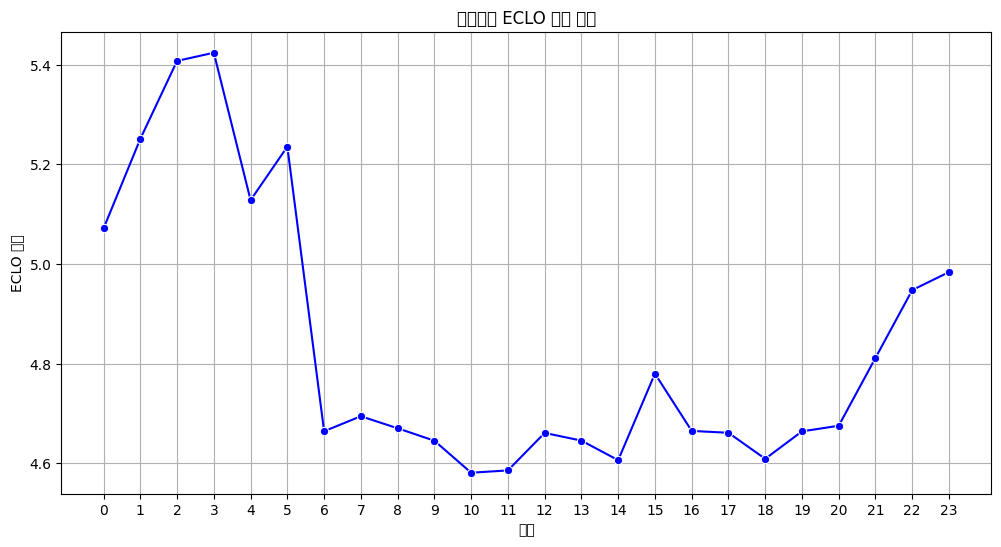

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 '시간'과 'ECLO' 열 선택
time_eclo_df = train_df[['시간', 'ECLO']]

# NaN 값이 있는 행 제거 (필요에 따라 처리)
time_eclo_df = time_eclo_df.dropna()

# '시간'을 기준으로 ECLO의 평균 계산
average_eclo_by_hour = time_eclo_df.groupby('시간')['ECLO'].mean().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_eclo_by_hour, x='시간', y='ECLO', marker='o', color='blue')
plt.title('시간대별 ECLO 평균 분포')
plt.xlabel('시간')
plt.ylabel('ECLO 평균')
plt.xticks(range(24))  # x 축 레이블을 0부터 23까지 표시
plt.grid(True)
plt.show()


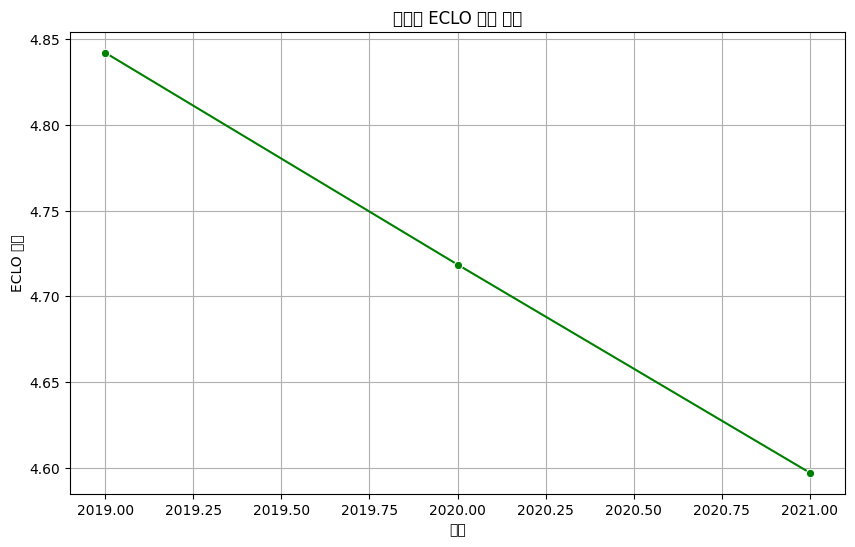

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 '연'과 'ECLO' 열 선택
year_eclo_df = train_df[['연', 'ECLO']]

# NaN 값이 있는 행 제거 (필요에 따라 처리)
year_eclo_df = year_eclo_df.dropna()

# '연'을 기준으로 ECLO의 평균 계산
average_eclo_by_year = year_eclo_df.groupby('연')['ECLO'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_eclo_by_year, x='연', y='ECLO', marker='o', color='green')
plt.title('연도별 ECLO 평균 분포')
plt.xlabel('연도')
plt.ylabel('ECLO 평균')
plt.grid(True)
plt.show()


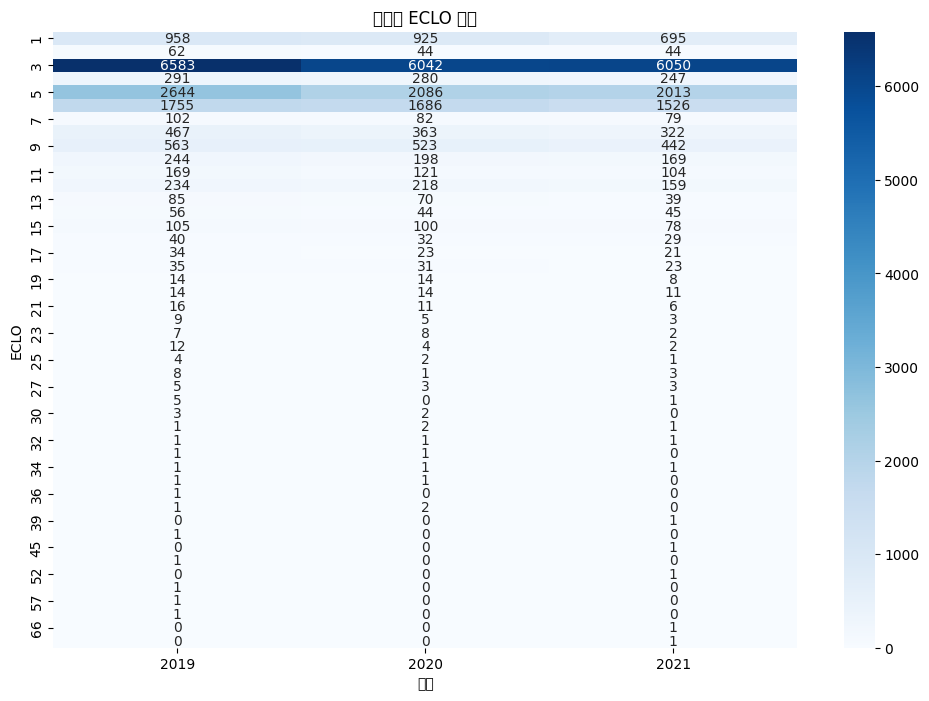

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임에서 '연'과 'ECLO' 열 선택
year_eclo_df = train_df[['연', 'ECLO']]

# NaN 값이 있는 행 제거 (필요에 따라 처리)
year_eclo_df = year_eclo_df.dropna()

# '연'을 기준으로 ECLO의 빈도 계산
eclo_counts_by_year = year_eclo_df.groupby('연')['ECLO'].value_counts().unstack().T.fillna(0)

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(eclo_counts_by_year, cmap='Blues', annot=True, fmt='.0f')
plt.title('연도별 ECLO 빈도')
plt.xlabel('연도')
plt.ylabel('ECLO')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
categorical_features.append('월')
categorical_features.append('시간')
display(categorical_features)


for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_df[i] = le.transform(test_df[i])

display(train_x.head())
display(test_df.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2', '월', '시간']

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.627926,4.712888,4.712878,3.817650,2019,4.661716,1,5.071256,4.726704,4.541610,4.282449,4.671841,4.599599,391.0,2.0,11.0,0.0,0.0
1,4.627926,4.779150,4.712878,3.817650,2019,4.661716,1,5.071256,4.726704,4.618441,4.738938,4.671841,4.599599,932.0,NaN,0.0,1.0,3.0
2,4.627926,4.712888,4.712878,3.817650,2019,4.661716,1,5.251121,4.726704,4.727300,4.842715,4.671841,4.599599,473.0,5.0,NaN,NaN,NaN
3,4.627926,4.712888,4.712878,4.944597,2019,4.661716,1,5.407692,4.726704,4.687669,4.208920,4.671841,4.599599,534.0,11.0,0.0,9.0,5.0
4,4.627926,4.712888,4.712878,4.944597,2019,4.661716,1,5.128065,4.726704,4.889534,4.549091,4.671841,4.599599,2057.0,NaN,0.0,1.0,0.0


,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.920811,4.712888,4.712878,3.817650,2022,4.661716,1,5.251121,4.726704,4.727300,4.881657,4.882281,5.006142,700.0,5.0,NaN,NaN,NaN
1,4.920811,4.712888,4.712878,3.817650,2022,4.661716,1,5.251121,4.726704,4.727300,4.563008,4.671841,4.599599,NaN,10.0,0.0,0.0,2.0
2,4.920811,4.712888,4.712878,4.944597,2022,4.661716,1,5.128065,4.726704,4.727300,4.945578,4.882281,5.006142,NaN,1.0,NaN,NaN,NaN
3,4.920811,4.712888,4.712878,4.944597,2022,4.661716,1,5.128065,4.726704,4.727300,4.438172,4.671841,4.599599,NaN,7.0,0.0,2.0,1.0
4,4.920811,4.712888,4.712878,4.944597,2022,4.661716,1,4.664000,4.726704,4.618441,4.738938,4.882281,5.006142,932.0,NaN,0.0,1.0,3.0


In [ ]:
# 각 열의 결측치 확인
missing_values = train_x.isnull().sum()

# 결측치 개수 출력
print(missing_values)

요일            0
기상상태          0
노면상태          0
사고유형          0
연             0
월             0
일             0
시간            0
도시            0
구             0
동             0
도로형태1         0
도로형태2         0
설치개수       9513
cnt       18426
급지구분_1     6543
급지구분_2     6543
급지구분_3     6543
dtype: int64


In [ ]:
# '연' 컬럼에 2019를 빼기
train_x['연'] = train_x['연'] - 2019
test_df['연'] = test_df['연'] - 2019

In [ ]:
train_x.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
# '도시' 열 삭제
train_x = train_x.drop(columns=['도시'])
test_df = test_df.drop(columns=['도시'])

train_x = train_x.drop(columns=['일'])
test_df = test_df.drop(columns=['일'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 정규화할 열 선택
columns_to_normalize = ['설치개수', 'cnt', '급지구분_1', '급지구분_2', '급지구분_3']

# Min-Max Scaling을 적용할 스케일러 생성
scaler = MinMaxScaler()

# train_x에 대해 정규화
train_x[columns_to_normalize] = scaler.fit_transform(train_x[columns_to_normalize])

# test_df에 대해 정규화 (train_x의 스케일러를 사용하여 동일한 스케일 적용)
test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

# 정규화된 train_x 확인
print("Normalized train_x:")
print(train_x.head())

# 정규화된 test_df 확인
print("\nNormalized test_df:")
print(test_df.head())

Normalized train_x:
         요일      기상상태      노면상태      사고유형  연         월        시간         구  \
0  4.627926  4.712888  4.712878  3.817650  0  4.661716  5.071256  4.541610   
1  4.627926  4.779150  4.712878  3.817650  0  4.661716  5.071256  4.618441   
2  4.627926  4.712888  4.712878  3.817650  0  4.661716  5.251121  4.727300   
3  4.627926  4.712888  4.712878  4.944597  0  4.661716  5.407692  4.687669   
4  4.627926  4.712888  4.712878  4.944597  0  4.661716  5.128065  4.889534   

          동     도로형태1     도로형태2      설치개수       cnt  급지구분_1    급지구분_2  \
0  4.282449  4.671841  4.599599  0.072717  0.066667    0.55  0.000000   
1  4.738938  4.671841  4.599599  0.173331  0.000000    0.00  0.033333   
2  4.842715  4.671841  4.599599  0.087967  0.166667    0.00  0.000000   
3  4.208920  4.671841  4.599599  0.099312  0.366667    0.00  0.300000   
4  4.549091  4.671841  4.599599  0.382555  0.000000    0.00  0.033333   

     급지구분_3  
0  0.000000  
1  0.103448  
2  0.000000  
3  0.172414  
4 

In [ ]:
train_x

,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.627926,4.712888,4.712878,3.817650,0,4.661716,5.071256,4.541610,4.282449,4.671841,4.599599,0.072717,0.066667,0.55,0.000000,0.000000
1,4.627926,4.779150,4.712878,3.817650,0,4.661716,5.071256,4.618441,4.738938,4.671841,4.599599,0.173331,0.000000,0.00,0.033333,0.103448
2,4.627926,4.712888,4.712878,3.817650,0,4.661716,5.251121,4.727300,4.842715,4.671841,4.599599,0.087967,0.166667,0.00,0.000000,0.000000
3,4.627926,4.712888,4.712878,4.944597,0,4.661716,5.407692,4.687669,4.208920,4.671841,4.599599,0.099312,0.366667,0.00,0.300000,0.172414
4,4.627926,4.712888,4.712878,4.944597,0,4.661716,5.128065,4.889534,4.549091,4.671841,4.599599,0.382555,0.000000,0.00,0.033333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.663746,4.727300,4.913420,4.882281,5.006142,0.000000,0.033333,0.00,0.000000,0.000000
39605,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.663746,4.618441,4.293963,4.671841,4.599599,0.156779,0.000000,0.00,0.000000,0.172414
39606,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.811321,4.618441,4.648867,4.882281,5.006142,0.030500,0.000000,0.00,0.033333,0.000000
39607,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.947543,4.618441,4.672002,4.065962,4.599599,0.039055,0.000000,0.00,0.000000,0.034483


In [ ]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.920811,4.712888,4.712878,3.817650,3,4.661716,5.251121,4.727300,4.881657,4.882281,5.006142,0.130184,0.166667,0.0,0.000000,0.000000
1,4.920811,4.712888,4.712878,3.817650,3,4.661716,5.251121,4.727300,4.563008,4.671841,4.599599,0.000000,0.333333,0.0,0.000000,0.068966
2,4.920811,4.712888,4.712878,4.944597,3,4.661716,5.128065,4.727300,4.945578,4.882281,5.006142,0.000000,0.033333,0.0,0.000000,0.000000
3,4.920811,4.712888,4.712878,4.944597,3,4.661716,5.128065,4.727300,4.438172,4.671841,4.599599,0.000000,0.233333,0.0,0.066667,0.034483
4,4.920811,4.712888,4.712878,4.944597,3,4.661716,4.664000,4.618441,4.738938,4.882281,5.006142,0.173331,0.000000,0.0,0.033333,0.103448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,4.920811,4.712888,4.712878,4.944597,3,4.544451,4.608593,4.623681,4.492281,4.671841,6.555670,1.000000,0.866667,1.0,0.033333,0.000000
10959,4.920811,4.712888,4.712878,4.944597,3,4.544451,4.608593,4.727300,4.928144,4.671841,4.599599,0.000000,0.166667,0.0,0.000000,0.000000
10960,4.920811,4.712888,4.712878,4.944597,3,4.544451,4.675023,4.727300,5.355036,4.671841,4.599599,0.000000,0.000000,0.0,0.000000,0.000000
10961,4.920811,4.712888,4.712878,4.944597,3,4.544451,4.675023,4.727300,5.079498,4.882281,4.863035,0.000000,0.233333,0.0,0.000000,0.000000


In [ ]:
train_y

0         5
1         3
2         3
3         5
4         3
         ..
39604     3
39605     3
39606    10
39607     3
39608     6
Name: ECLO, Length: 39609, dtype: int64

In [ ]:
# from scipy import stats

# # '연' 컬럼을 대상으로 Z-score를 계산하여 이상치 제거
# def remove_outliers(df, column_name, z_threshold=3):
#     z_scores = np.abs(stats.zscore(df[column_name]))
#     filtered_df = df[(z_scores < z_threshold)]
#     return filtered_df

# # '연' 컬럼의 이상치를 제거
# train_x_no_outliers = remove_outliers(train_x, '연')

# TRAIN

In [ ]:
test_x = test_df

In [ ]:

def rmsle(y_true, y_pred):
    y_true = tf.maximum(tf.cast(y_true, tf.float32), 0)
    y_pred = tf.maximum(tf.cast(y_pred, tf.float32), 0)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
import tensorflow as tf

# GPU를 사용할 수 있는지 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 모델을 만드는 함수
def create_model():
    input_layer = tf.keras.Input(shape=(len(train_x.columns),))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

# 모델 생성
model = create_model()

# 모델 학습
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)


Num GPUs Available:  1
Epoch 1/100
1114/1114 [==============================] - 23s 11ms/step - loss: 0.4836 - metric_fn: 0.4836 - val_loss: 0.4333 - val_metric_fn: 0.4333 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 9s 8ms/step - loss: 0.4484 - metric_fn: 0.4484 - val_loss: 0.4256 - val_metric_fn: 0.4256 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 8s 7ms/step - loss: 0.4460 - metric_fn: 0.4460 - val_loss: 0.4235 - val_metric_fn: 0.4235 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 5s 4ms/step - loss: 0.4442 - metric_fn: 0.4442 - val_loss: 0.4239 - val_metric_fn: 0.4239 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 5s 5ms/step - loss: 0.4435 - metric_fn: 0.4435 - val_loss: 0.4261 - val_metric_fn: 0.4261 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 6s 6ms/step - loss: 0.4432 - metric_fn: 0.4432 - val_loss: 0.4236 - val_metric_fn: 0.4235 - lr: 0.0010
Epoch 7/100
111

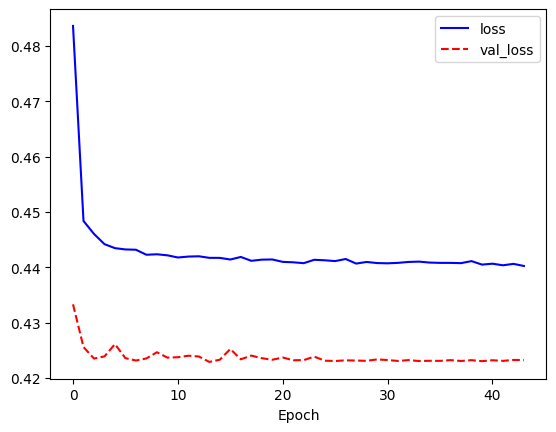

In [ ]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
train_x

,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.627926,4.712888,4.712878,3.817650,0,4.661716,5.071256,4.541610,4.282449,4.671841,4.599599,0.072717,0.066667,0.55,0.000000,0.000000
1,4.627926,4.779150,4.712878,3.817650,0,4.661716,5.071256,4.618441,4.738938,4.671841,4.599599,0.173331,0.000000,0.00,0.033333,0.103448
2,4.627926,4.712888,4.712878,3.817650,0,4.661716,5.251121,4.727300,4.842715,4.671841,4.599599,0.087967,0.166667,0.00,0.000000,0.000000
3,4.627926,4.712888,4.712878,4.944597,0,4.661716,5.407692,4.687669,4.208920,4.671841,4.599599,0.099312,0.366667,0.00,0.300000,0.172414
4,4.627926,4.712888,4.712878,4.944597,0,4.661716,5.128065,4.889534,4.549091,4.671841,4.599599,0.382555,0.000000,0.00,0.033333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.663746,4.727300,4.913420,4.882281,5.006142,0.000000,0.033333,0.00,0.000000,0.000000
39605,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.663746,4.618441,4.293963,4.671841,4.599599,0.156779,0.000000,0.00,0.000000,0.172414
39606,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.811321,4.618441,4.648867,4.882281,5.006142,0.030500,0.000000,0.00,0.033333,0.000000
39607,4.600906,4.712888,4.712878,4.944597,2,4.544451,4.947543,4.618441,4.672002,4.065962,4.599599,0.039055,0.000000,0.00,0.000000,0.034483


In [ ]:
train_y

0         5
1         3
2         3
3         5
4         3
         ..
39604     3
39605     3
39606    10
39607     3
39608     6
Name: ECLO, Length: 39609, dtype: int64

# SUBMIT

In [ ]:
sample_submission = pd.read_csv('경로/open/sample_submission.csv')

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

sample_submission.to_csv("경로/파일명.csv", index=False)

343/343 [==============================] - 1s 2ms/step
